In [1]:
import sys
sys.path.insert(1, '/home/kheyblom/aura/codes/my_functions/')
sys.path.insert(1, '/net/venus/kenes/user/kheyblom/projects/tags/')
sys.path.insert(1, '/net/venus/kenes/user/kheyblom/projects/isotopes/')
from importlib import reload
import myfunc as my; reload(my)
import MyFunc as myold; reload(myold)
import myplot as myplt; reload(myplt)
import tag_func as mytag; reload(mytag)
import iso_func as myiso; reload(myiso)
import pickle
import xarray as xr
from xarray.ufuncs import trunc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FixedLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline
from scipy import signal, stats, interpolate, integrate
from IPython.display import clear_output, display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import dask
from dask import delayed, compute
import cftime as cf
from datetime import timedelta
import warnings; warnings.simplefilter('ignore')
from numba import njit, prange, config, threading_layer
config.THREADING_LAYER = 'threadsafe'

In [2]:
tags_lat, tags_lon = mytag.get_tags_latlon()
tagid_lat, tagid_lon = list(tags_lat.keys()), list(tags_lon.keys())
ntag_lat, ntag_lon = len(tagid_lat), len(tagid_lon)

In [3]:
data_dir = '/kenes/data/kheyblom/icesm-output/mon/'

def open_var(label,var_in,yr1=1850,yr2=2099):
    data = xr.open_dataset('{0}/{1}/{1}.{2}.nc'.format(data_dir,label,var_in))
    data['time'] = data.time_bnds[:,0].compute()
    data = data.sel(time=slice(str(yr1),str(yr2)))
    return data
def open_mbr(label,var,yr1=1850,yr2=2099):
    data = []
    for v in var:
        data.append(open_var(label,v,yr1=yr1,yr2=yr2))
    data = xr.merge(data)
    return data
def open_data(mbrs_label,mbrs_pre,var,yr1=1850,yr2=2099):
    hist_labels = [mbrs_fix['hist']+'_'+suf for suf in mbrs_label]
    rcp_labels = [mbrs_fix['rcp85']+'_'+suf for suf in mbrs_label]
    data = []
    for i,imbr in enumerate(mbrs_label):
        print('working on: {}'.format(imbr))
        try:
            data.append(xr.concat([open_mbr(hist_labels[i],var,yr1=yr1,yr2='2005'),open_mbr(rcp_labels[i],var,yr1=yr1,yr2=yr2)],'time'))
        except FileNotFoundError:
            try:
                data.append(open_mbr(hist_labels[i],var,yr1=yr1,yr2='2005'))
            except FileNotFoundError:
                data.append(open_mbr(rcp_labels[i],var,yr1=yr1,yr2=yr2))
    data = xr.concat(data,'member_id')
    data['member_id'] = mbrs_label
    return data

In [4]:
%%time
reload(mytag)

mbrs = {'hist-tags': ['historical-iso-r3-tags']}
mbrs_label = ['r3']


%%time
mbrs_pre = {'hist':      'iso-hist',
            'rcp85':     'iso-rcp85'}
var = ['TREFHT','PRECC','PRECL']

mbrs_label = ['r1','r2','r3','r4','r5',
              'r3-tag-a','r4-tag-a','r5-tag-a',
              'r3-tag-b','r4-tag-b','r5-tag-b',
              'r3-tag-c']    
data = open_data(mbrs_label,mbrs_pre,var,yr1=1920,yr2=2099)



start_yrs = [1949,1999,2069]

#precip tagged to lat bands
print('open lat precip')
precip_tags_lat = ['PRECRC_{}r'.format(x) for x in tagid_lat] + ['PRECRL_{}R'.format(x) for x in tagid_lat] + \
                    ['PRECSC_{}s'.format(x) for x in tagid_lat] + ['PRECSL_{}S'.format(x) for x in tagid_lat]
data_lat = mytag.open_tagvars(precip_tags_lat,mbrs,mbrs_label,remove_years=start_yrs)
pr_lat = []
for i,itag in enumerate(tagid_lat):  
    pr_lat.append(data_lat['PRECRC_{}r'.format(itag)] + data_lat['PRECRL_{}R'.format(itag)] + \
                  data_lat['PRECSC_{}s'.format(itag)] + data_lat['PRECSL_{}S'.format(itag)])
pr_lat = xr.concat(pr_lat,'tagid')*1000 #mm/s
pr_lat['tagid'] = tagid_lat
pr_lat = pr_lat.sel(time=pr_lat.time.dt.year.isin(yrs_grab))


#precip tagged to lon bands
print('open lon precip')
precip_tags_lon = ['PRECRC_{}r'.format(x) for x in tagid_lon] + ['PRECRL_{}R'.format(x) for x in tagid_lon] + \
                    ['PRECSC_{}s'.format(x) for x in tagid_lon] + ['PRECSL_{}S'.format(x) for x in tagid_lon]
data_lon = mytag.open_tagvars(precip_tags_lon,mbrs,mbrs_label,remove_years=start_yrs)
pr_lon = []
for i,itag in enumerate(tagid_lon):  
    pr_lon.append(data_lon['PRECRC_{}r'.format(itag)] + data_lon['PRECRL_{}R'.format(itag)] + \
                  data_lon['PRECSC_{}s'.format(itag)] + data_lon['PRECSL_{}S'.format(itag)])
pr_lon = xr.concat(pr_lon,'tagid')*1000 #mm/s
pr_lon['tagid'] = tagid_lon
pr_lon = pr_lon.sel(time=pr_lon.time.dt.year.isin(yrs_grab))

# precip grid
lats = data_lat.lat.data
lons = data_lat.lon.data

# tag grid
lat_bnds_tags, lon_bnds_tags = mytag.tags_truebnds(list(tags_lat.values()),list(tags_lon.values()))
lat_tags = np.mean(lat_bnds_tags,axis=1)
lon_tags = np.mean(lon_bnds_tags,axis=1)
nlat_tags = len(lat_tags)
nlon_tags = len(lon_tags)

times = data_lat.time.data

open lat precip
opening: r3
open lon precip
opening: r3
CPU times: user 26.5 s, sys: 3.03 s, total: 29.5 s
Wall time: 29.6 s


In [5]:
## pull grid cell areas ##
data_area = xr.open_dataset('/net/aeolus/aura/data/cmip6/fx/areacella/areacella_fx_CESM2_historical_r2i1p1f1_gn.nc').areacella #m2

In [111]:
def sum_regrid(data_gn,lat_tags,lon_tags):
    nlat_tags = len(lat_tags)
    nlon_tags = len(lon_tags)
    data_gr = np.zeros((nlat_tags,nlon_tags))
    for i in range(nlat_tags):
        for j in range(nlon_tags):
            data_gr[i,j] = float(data_gn.sel(lat=slice(*lat_bnds_tags[i]),lon=slice(*lon_bnds_tags[j])).sum())
    return data_gr

def pr_src_grid(prtag_lat,prtag_lon):
    '''
    Approximate source location from lat and lon tags
    
    --> convolves lat and lon source regions by multiplying lat source precip distrbution by normalized lon ditribution
    
    input:
    --------
    prtag_lat, prtag_lon: vectors of source precip from each lat,lon band
    
    returns:
    --------
    approximated precip from a source region grid of lon x lat
    '''
    prtag_lon_norm = prtag_lon/np.sum(prtag_lon)
    pr_lon3, pr_lat3 = np.meshgrid(prtag_lon_norm,prtag_lat)
    return pr_lon3*pr_lat3

def rmse(x_approx,x_true):
    return np.sqrt(((x_approx-x_true)**2).mean())

# Open and compute

## **F$_e$**, **F$_p$**

In [7]:
%%time

pr_lat_base_gn = my.annualmean(pr_lat.sel(time=slice('1950','1979'))).mean('time')*data_area #kg/s
pr_lat_eoc_gn = my.annualmean(pr_lat.sel(time=slice('2070','2099'))).mean('time')*data_area #kg/s
pr_lat_base_gn = pr_lat_base_gn.compute()
pr_lat_eoc_gn = pr_lat_eoc_gn.compute()

pr_lon_base_gn = my.annualmean(pr_lon.sel(time=slice('1950','1979'))).mean('time')*data_area #kg/s
pr_lon_eoc_gn = my.annualmean(pr_lon.sel(time=slice('2070','2099'))).mean('time')*data_area #kg/s
pr_lon_base_gn = pr_lon_base_gn.compute()
pr_lon_eoc_gn = pr_lon_eoc_gn.compute()

CPU times: user 1min 17s, sys: 1min 22s, total: 2min 39s
Wall time: 4min 18s


In [8]:
%%time

pr_lat_base_gr = np.zeros((ntag_lat,nlat_tags,nlon_tags))
pr_lat_eoc_gr = np.zeros((ntag_lat,nlat_tags,nlon_tags))
for i in range(ntag_lat):
    pr_lat_base_gr[i,:,:] = sum_regrid(pr_lat_base_gn[i,:,:],lat_tags,lon_tags)
    pr_lat_eoc_gr[i,:,:] = sum_regrid(pr_lat_eoc_gn[i,:,:],lat_tags,lon_tags)

pr_lon_base_gr = np.zeros((ntag_lon,nlat_tags,nlon_tags))
pr_lon_eoc_gr = np.zeros((ntag_lon,nlat_tags,nlon_tags))
for i in range(ntag_lon):
    pr_lon_base_gr[i,:,:] = sum_regrid(pr_lon_base_gn[i,:,:],lat_tags,lon_tags)
    pr_lon_eoc_gr[i,:,:] = sum_regrid(pr_lon_eoc_gn[i,:,:],lat_tags,lon_tags)

CPU times: user 27 s, sys: 270 ms, total: 27.3 s
Wall time: 26.9 s


In [108]:
%%time

Fraw_base = np.zeros((nlat_tags*nlon_tags,nlat_tags*nlon_tags))
Fraw_eoc = np.zeros((nlat_tags*nlon_tags,nlat_tags*nlon_tags))
i = 0
for ilat in range(nlat_tags):
    for ilon in range(nlon_tags):
        pr_src_base = pr_src_grid(pr_lat_base_gr[:,ilat,ilon],pr_lon_base_gr[:,ilat,ilon])
        pr_src_eoc = pr_src_grid(pr_lat_eoc_gr[:,ilat,ilon],pr_lon_eoc_gr[:,ilat,ilon])
        Fraw_base[i,:] = pr_src_base.ravel()
        Fraw_eoc[i,:] = pr_src_eoc.ravel()
        i += 1
        
#normalize along j
Fe_base = Fraw_base/np.sum(Fraw_base,axis=0)
Fe_eoc = Fraw_eoc/np.sum(Fraw_eoc,axis=0)

#normalize along i
Fp_base = Fraw_base.T/np.sum(Fraw_base.T,axis=0)
Fp_eoc = Fraw_eoc.T/np.sum(Fraw_eoc.T,axis=0)

Fc_base = Fp_base@Fe_base
Fc_eoc = Fp_eoc@Fe_eoc

CPU times: user 183 ms, sys: 2.65 s, total: 2.83 s
Wall time: 93.5 ms


## **P**

In [11]:
pr_gn = pr_lat.sum('tagid')*data_area #kg/s

pr_base_gn = my.annualmean(pr_gn.sel(time=slice('1950','1979'))).mean('time')
pr_eoc_gn = my.annualmean(pr_gn.sel(time=slice('2070','2099'))).mean('time')

pr_base_gn = pr_base_gn.compute()
pr_eoc_gn = pr_eoc_gn.compute()

In [12]:
pr_base_gr = sum_regrid(pr_base_gn,lat_tags,lon_tags)
pr_eoc_gr = sum_regrid(pr_eoc_gn,lat_tags,lon_tags)

In [13]:
P_base = np.ravel(pr_base_gr)*np.eye(nlat_tags*nlon_tags) #stacks lat bands --> i.e. iterates lon within lat
P_eoc = np.ravel(pr_eoc_gr)*np.eye(nlat_tags*nlon_tags)

## **E**

In [14]:
%%time

mbrs_big = {'hist':       ['historical-iso-r3'],
            'rcp85':      ['rcp85_r3'],
            'hist-tags':  ['historical-iso-r3-tags'],
            'rcp85-tags': ['rcp85_r3-tags']}


data_e = myiso.open_vars(['QFLX_H2O'],
                         mbrs_big,mbrs_label)

opening: r3
CPU times: user 175 ms, sys: 5.48 ms, total: 180 ms
Wall time: 180 ms


In [15]:
data_e.QFLX_H2O.attrs

{'units': 'kg/m2/s',
 'long_name': 'Surface water flux for H2O',
 'cell_methods': 'time: mean'}

In [16]:
%%time

e_gn = data_e.QFLX_H2O*data_area #kg/s

e_base_gn = my.annualmean(e_gn.sel(time=slice('1950','1979'))).mean('time')
e_eoc_gn = my.annualmean(e_gn.sel(time=slice('2070','2099'))).mean('time')

e_base_gn = e_base_gn.compute()
e_eoc_gn = e_eoc_gn.compute()

CPU times: user 1.66 s, sys: 673 ms, total: 2.34 s
Wall time: 2.63 s


In [17]:
e_base_gr = sum_regrid(e_base_gn,lat_tags,lon_tags)
e_eoc_gr = sum_regrid(e_eoc_gn,lat_tags,lon_tags)

In [18]:
E_base = np.ravel(e_base_gr)*np.eye(nlat_tags*nlon_tags)
E_eoc = np.ravel(e_eoc_gr)*np.eye(nlat_tags*nlon_tags)

# $F_{p} \cdot P$  vs.  $inv(F_{e}) \cdot P$

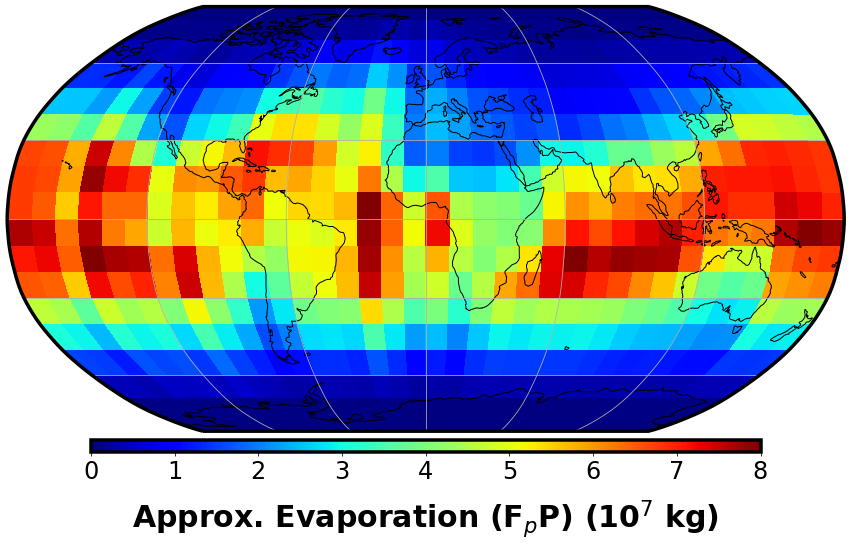

In [116]:
term = Fp_base@P_base

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Approx. Evaporation (F$_{p}$P) (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

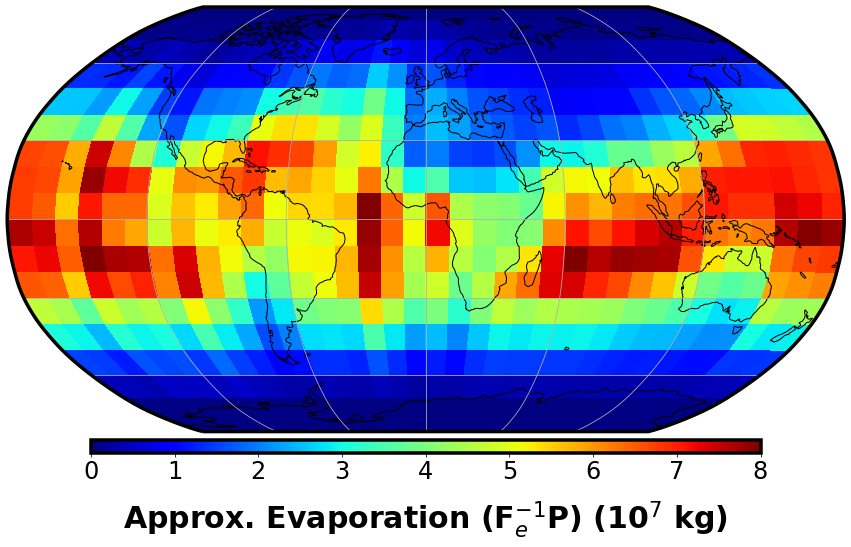

In [114]:
term = np.linalg.inv(Fe_base)@P_base

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Approx. Evaporation (F$_{e}^{-1}$P) (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

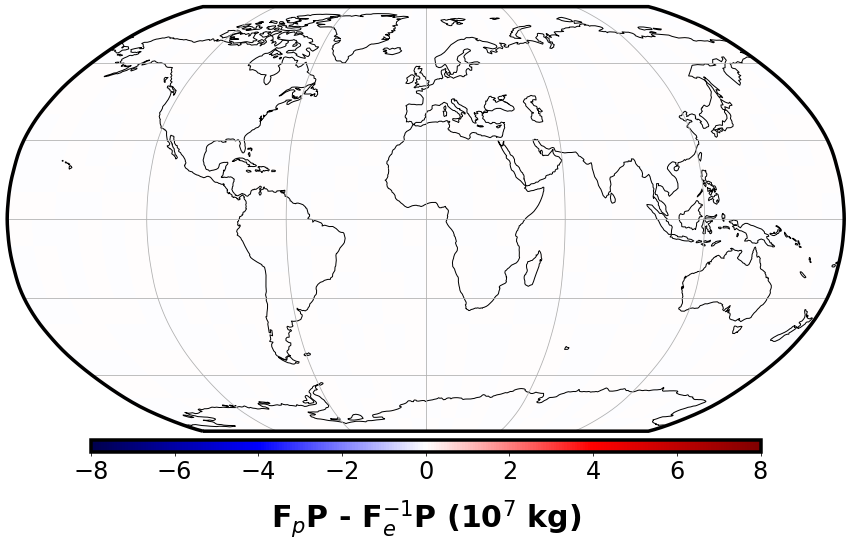

In [119]:
term = Fp_base@P_base-np.linalg.inv(Fe_base)@P_base

vmin, vmax= -8, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'F$_{p}$P - F$_{e}^{-1}$P (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='seismic', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

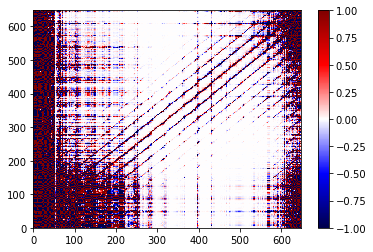

In [135]:
q = plt.pcolormesh(Fp_base-np.linalg.inv(Fe_base),vmin=-1,vmax=1,cmap='seismic')
plt.colorbar(q)

# E error

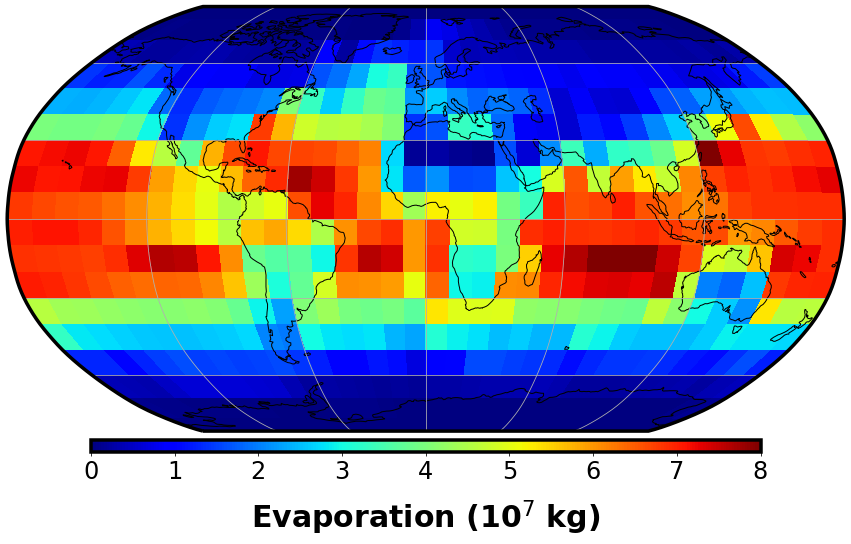

In [35]:
term = E_base

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Evaporation (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

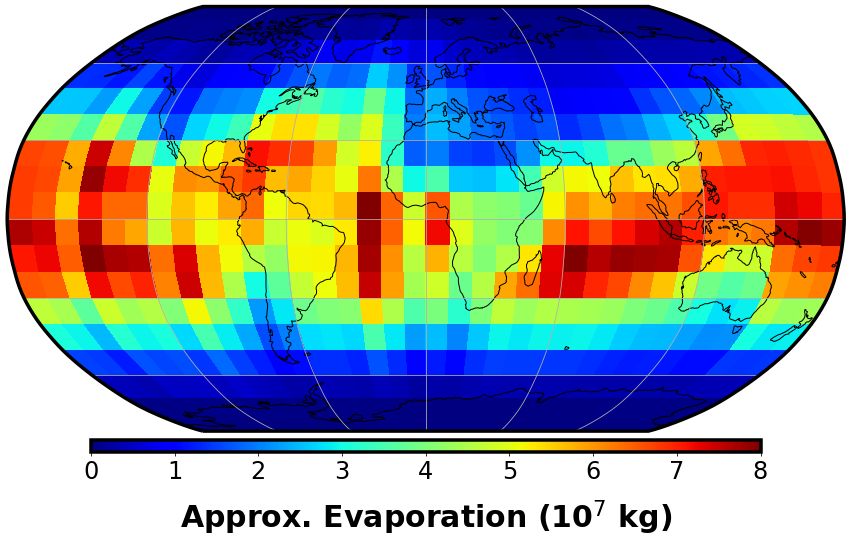

In [137]:
term = Fp_base@P_base

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Approx. Evaporation (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

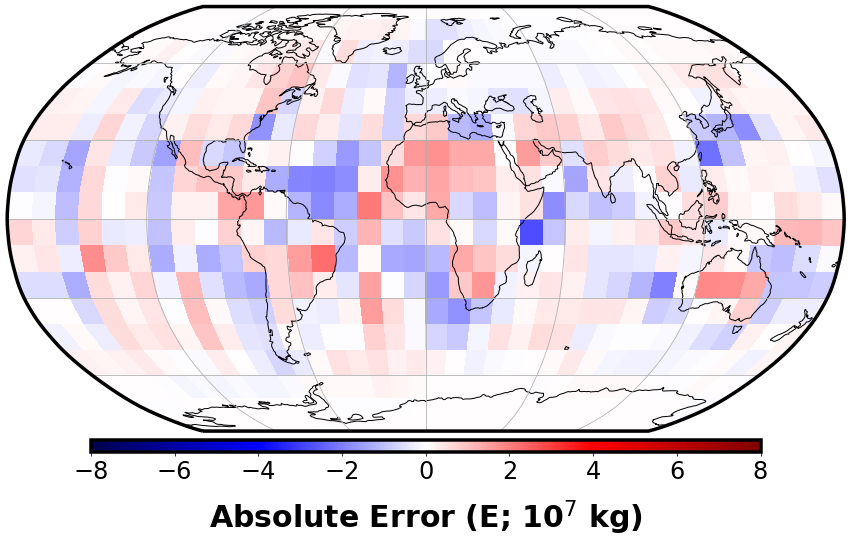

In [142]:
term = (Fp_base@P_base-E_base)

vmin, vmax= -8, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Absolute Error (E; 10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='seismic', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

In [143]:
rmse(Fp_base@P_base,E_base)/E_base.mean()

0.2131396030665738

# P error

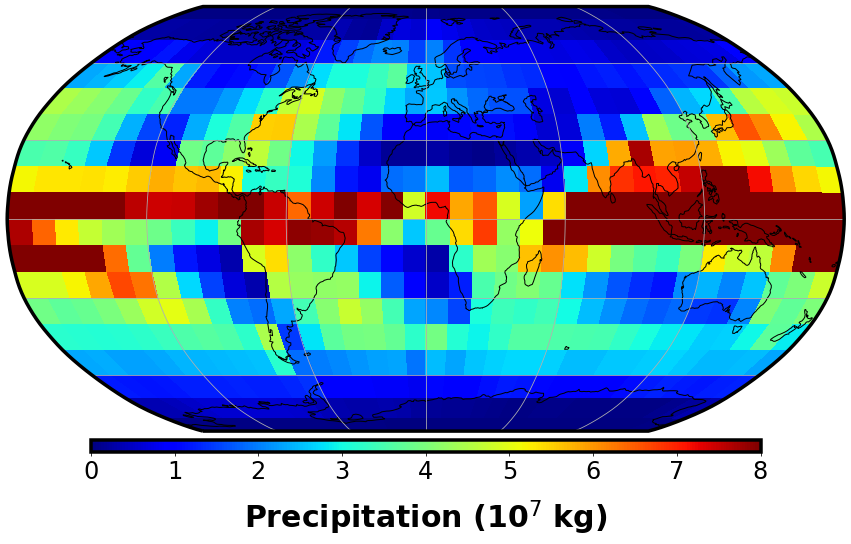

In [140]:
term = P_base

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Precipitation (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

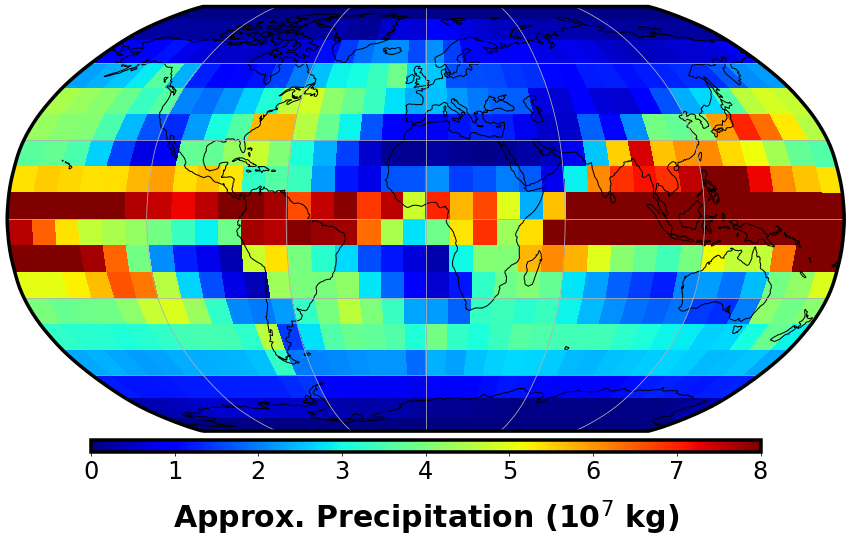

In [141]:
term = Fe_base@E_base

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Approx. Precipitation (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

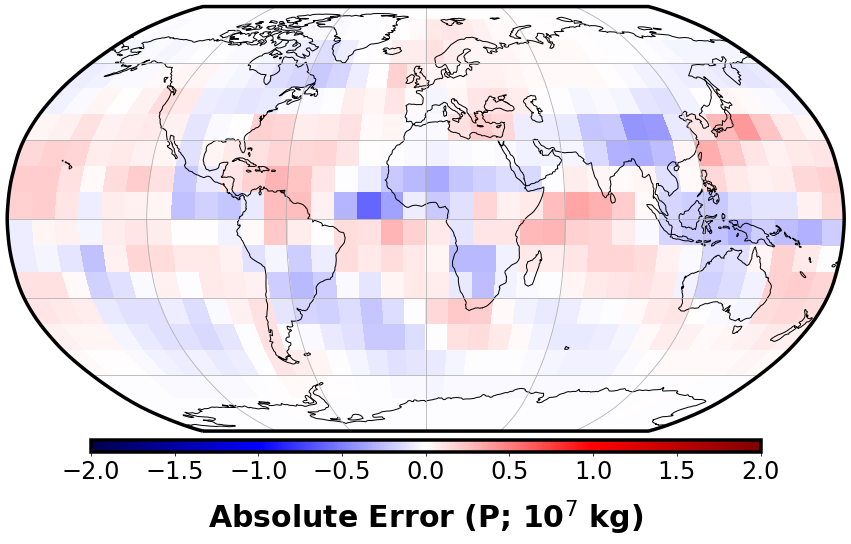

In [147]:
term = (Fe_base@E_base-P_base)

vmin, vmax= -2, 2
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Absolute Error (P; 10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='seismic', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

In [145]:
rmse(Fe_base@E_base,P_base)/P_base.mean()

0.03881382899518161

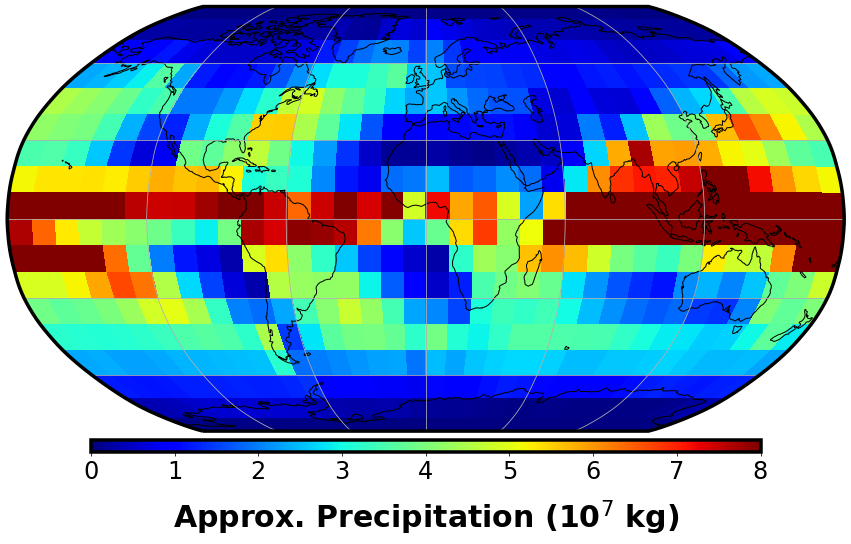

In [163]:
term = Fe_base@(Fp_base@P_base)

vmin, vmax= 0, 8
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Approx. Precipitation (10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

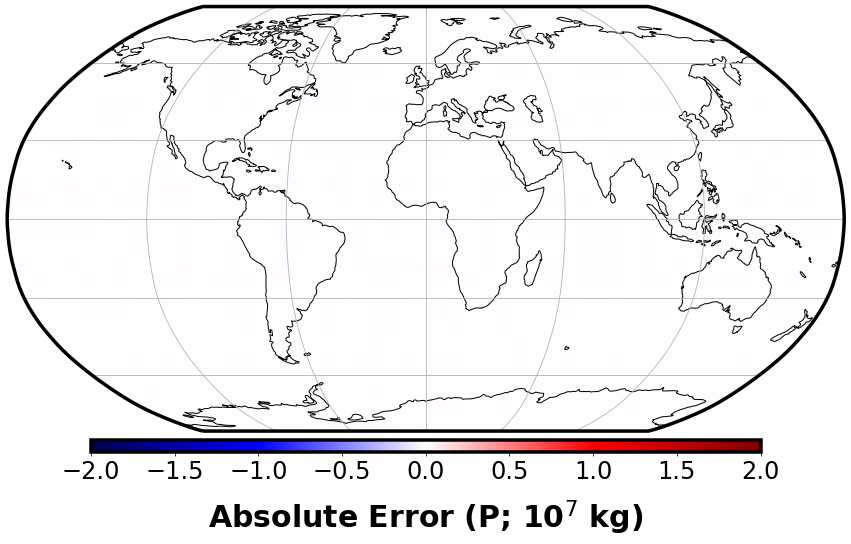

In [164]:
term = (Fe_base@(Fp_base@P_base)-P_base)

vmin, vmax= -2, 2
nticks = 9
fs1 = 30
fs2 = 24
cblabel = 'Absolute Error (P; 10$^{7}$ kg)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='seismic', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

In [165]:
rmse(Fe_base@(Fp_base@P_base),P_base)/P_base.mean()

5.617346060895756e-10

# P = E error

In [183]:
e_lat_base_gr = e_base_gr.sum(axis=1)
e_lon_base_gr = e_base_gr.sum(axis=0)

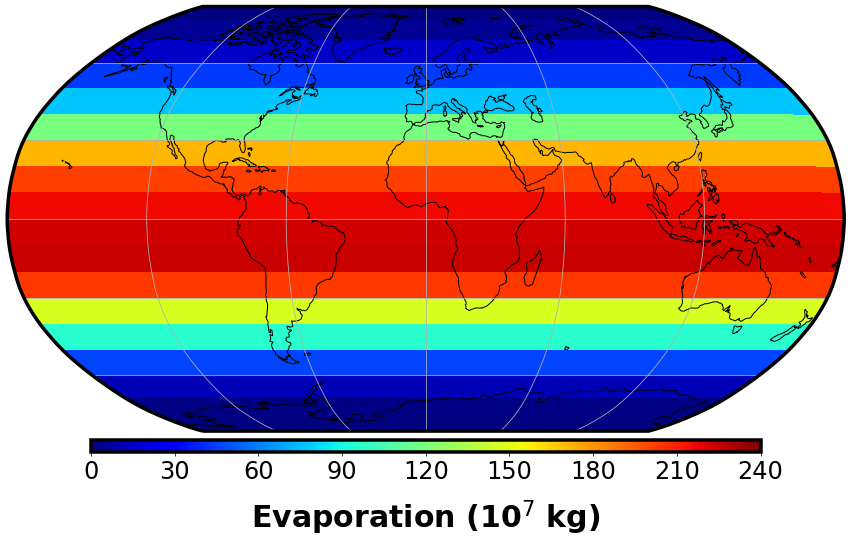

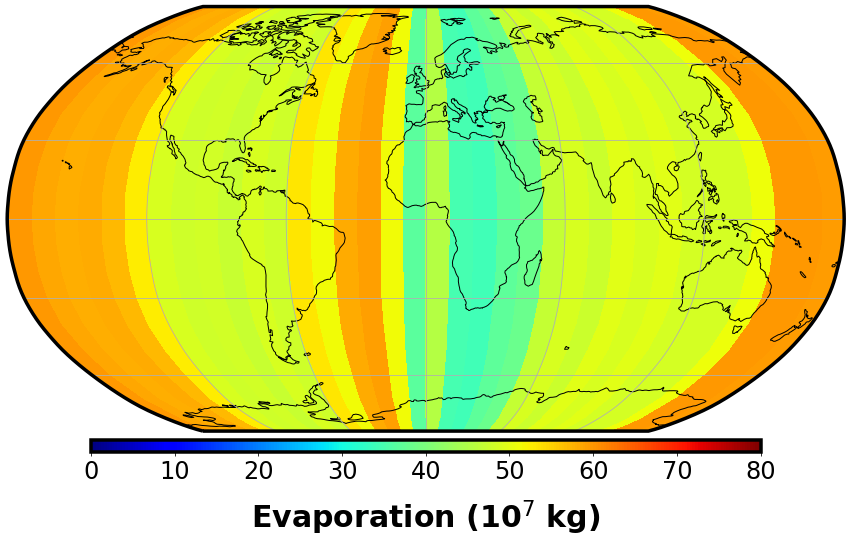

In [215]:
term_lon, term_lat = np.meshgrid(e_lon_base_gr,e_lat_base_gr)


nticks = 9
fs1 = 30
fs2 = 24

cblabel = 'Evaporation (10$^{7}$ kg)'

vmin, vmax= 0, 8*30
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lat/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

vmin, vmax= 0, 8*10
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lon/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

In [209]:
pr_lat_tag_base_gr = pr_lat_base_gr.sum(axis=2)
pr_lon_tag_base_gr = pr_lon_base_gr.sum(axis=1)

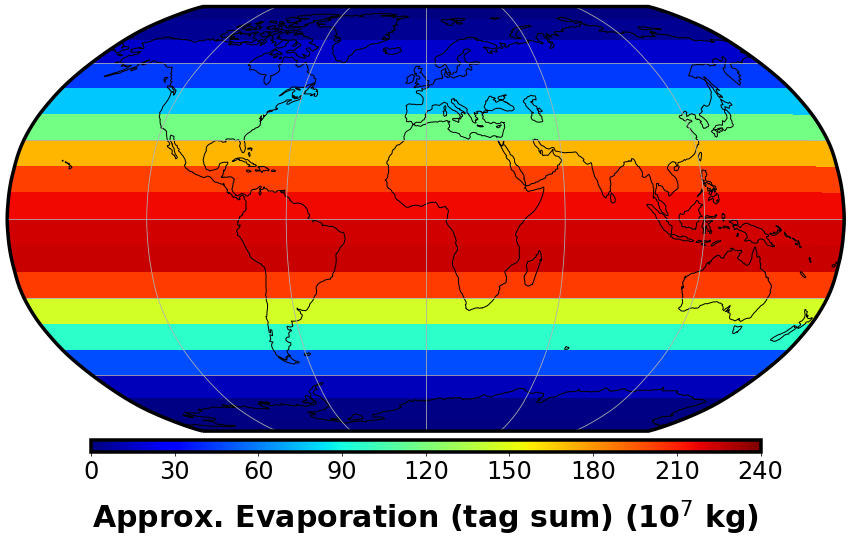

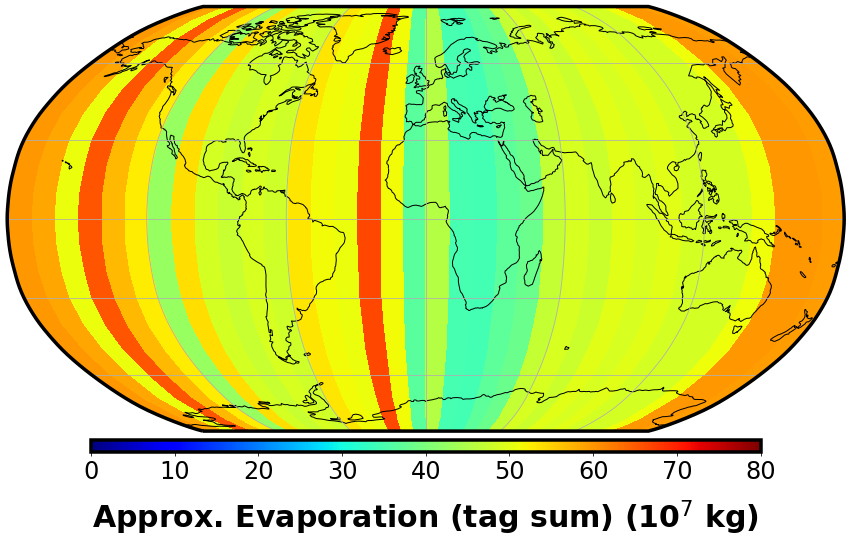

In [227]:
term_lon, term_lat = np.meshgrid(pr_lon_tag_base_gr.sum(axis=1),pr_lat_tag_base_gr.sum(axis=1))

nticks = 9
fs1 = 30
fs2 = 24

cblabel = 'Approx. Evaporation (tag sum) (10$^{7}$ kg)'

vmin, vmax= 0, 8*30
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lat/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

vmin, vmax= 0, 8*10
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lon/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

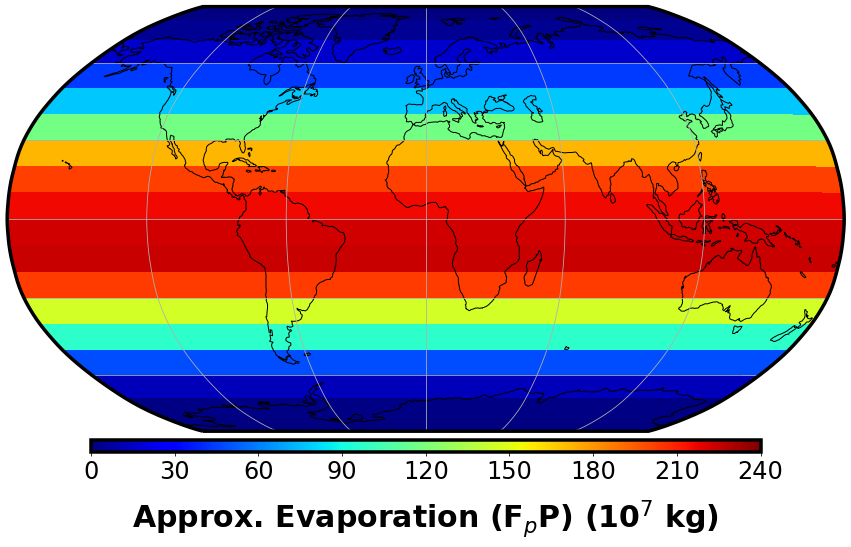

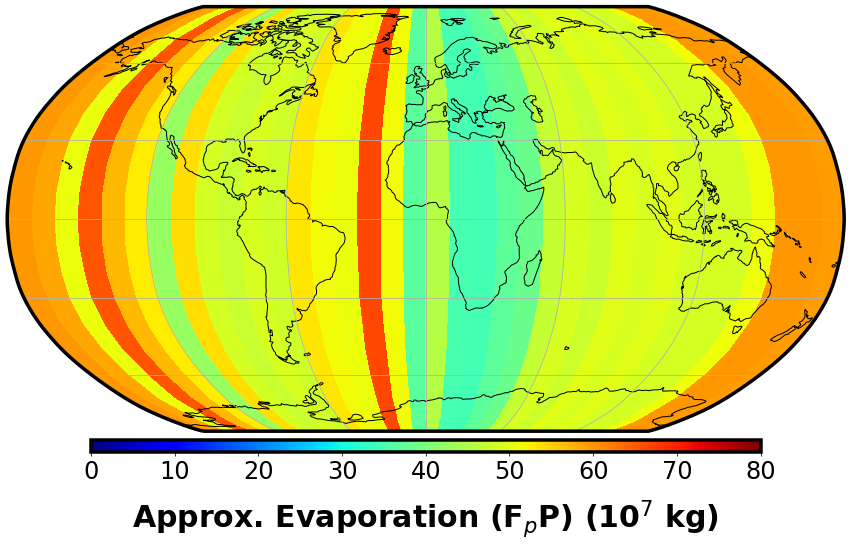

In [217]:
term_lon, term_lat = np.meshgrid(np.reshape(Fp_base@P_base,(ntag_lat,ntag_lon)).sum(axis=0),
                                 np.reshape(Fp_base@P_base,(ntag_lat,ntag_lon)).sum(axis=1))


nticks = 9
fs1 = 30
fs2 = 24

cblabel = 'Approx. Evaporation (F$_{p}$P) (10$^{7}$ kg)'

vmin, vmax= 0, 8*30
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lat/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

vmin, vmax= 0, 8*10
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lon/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

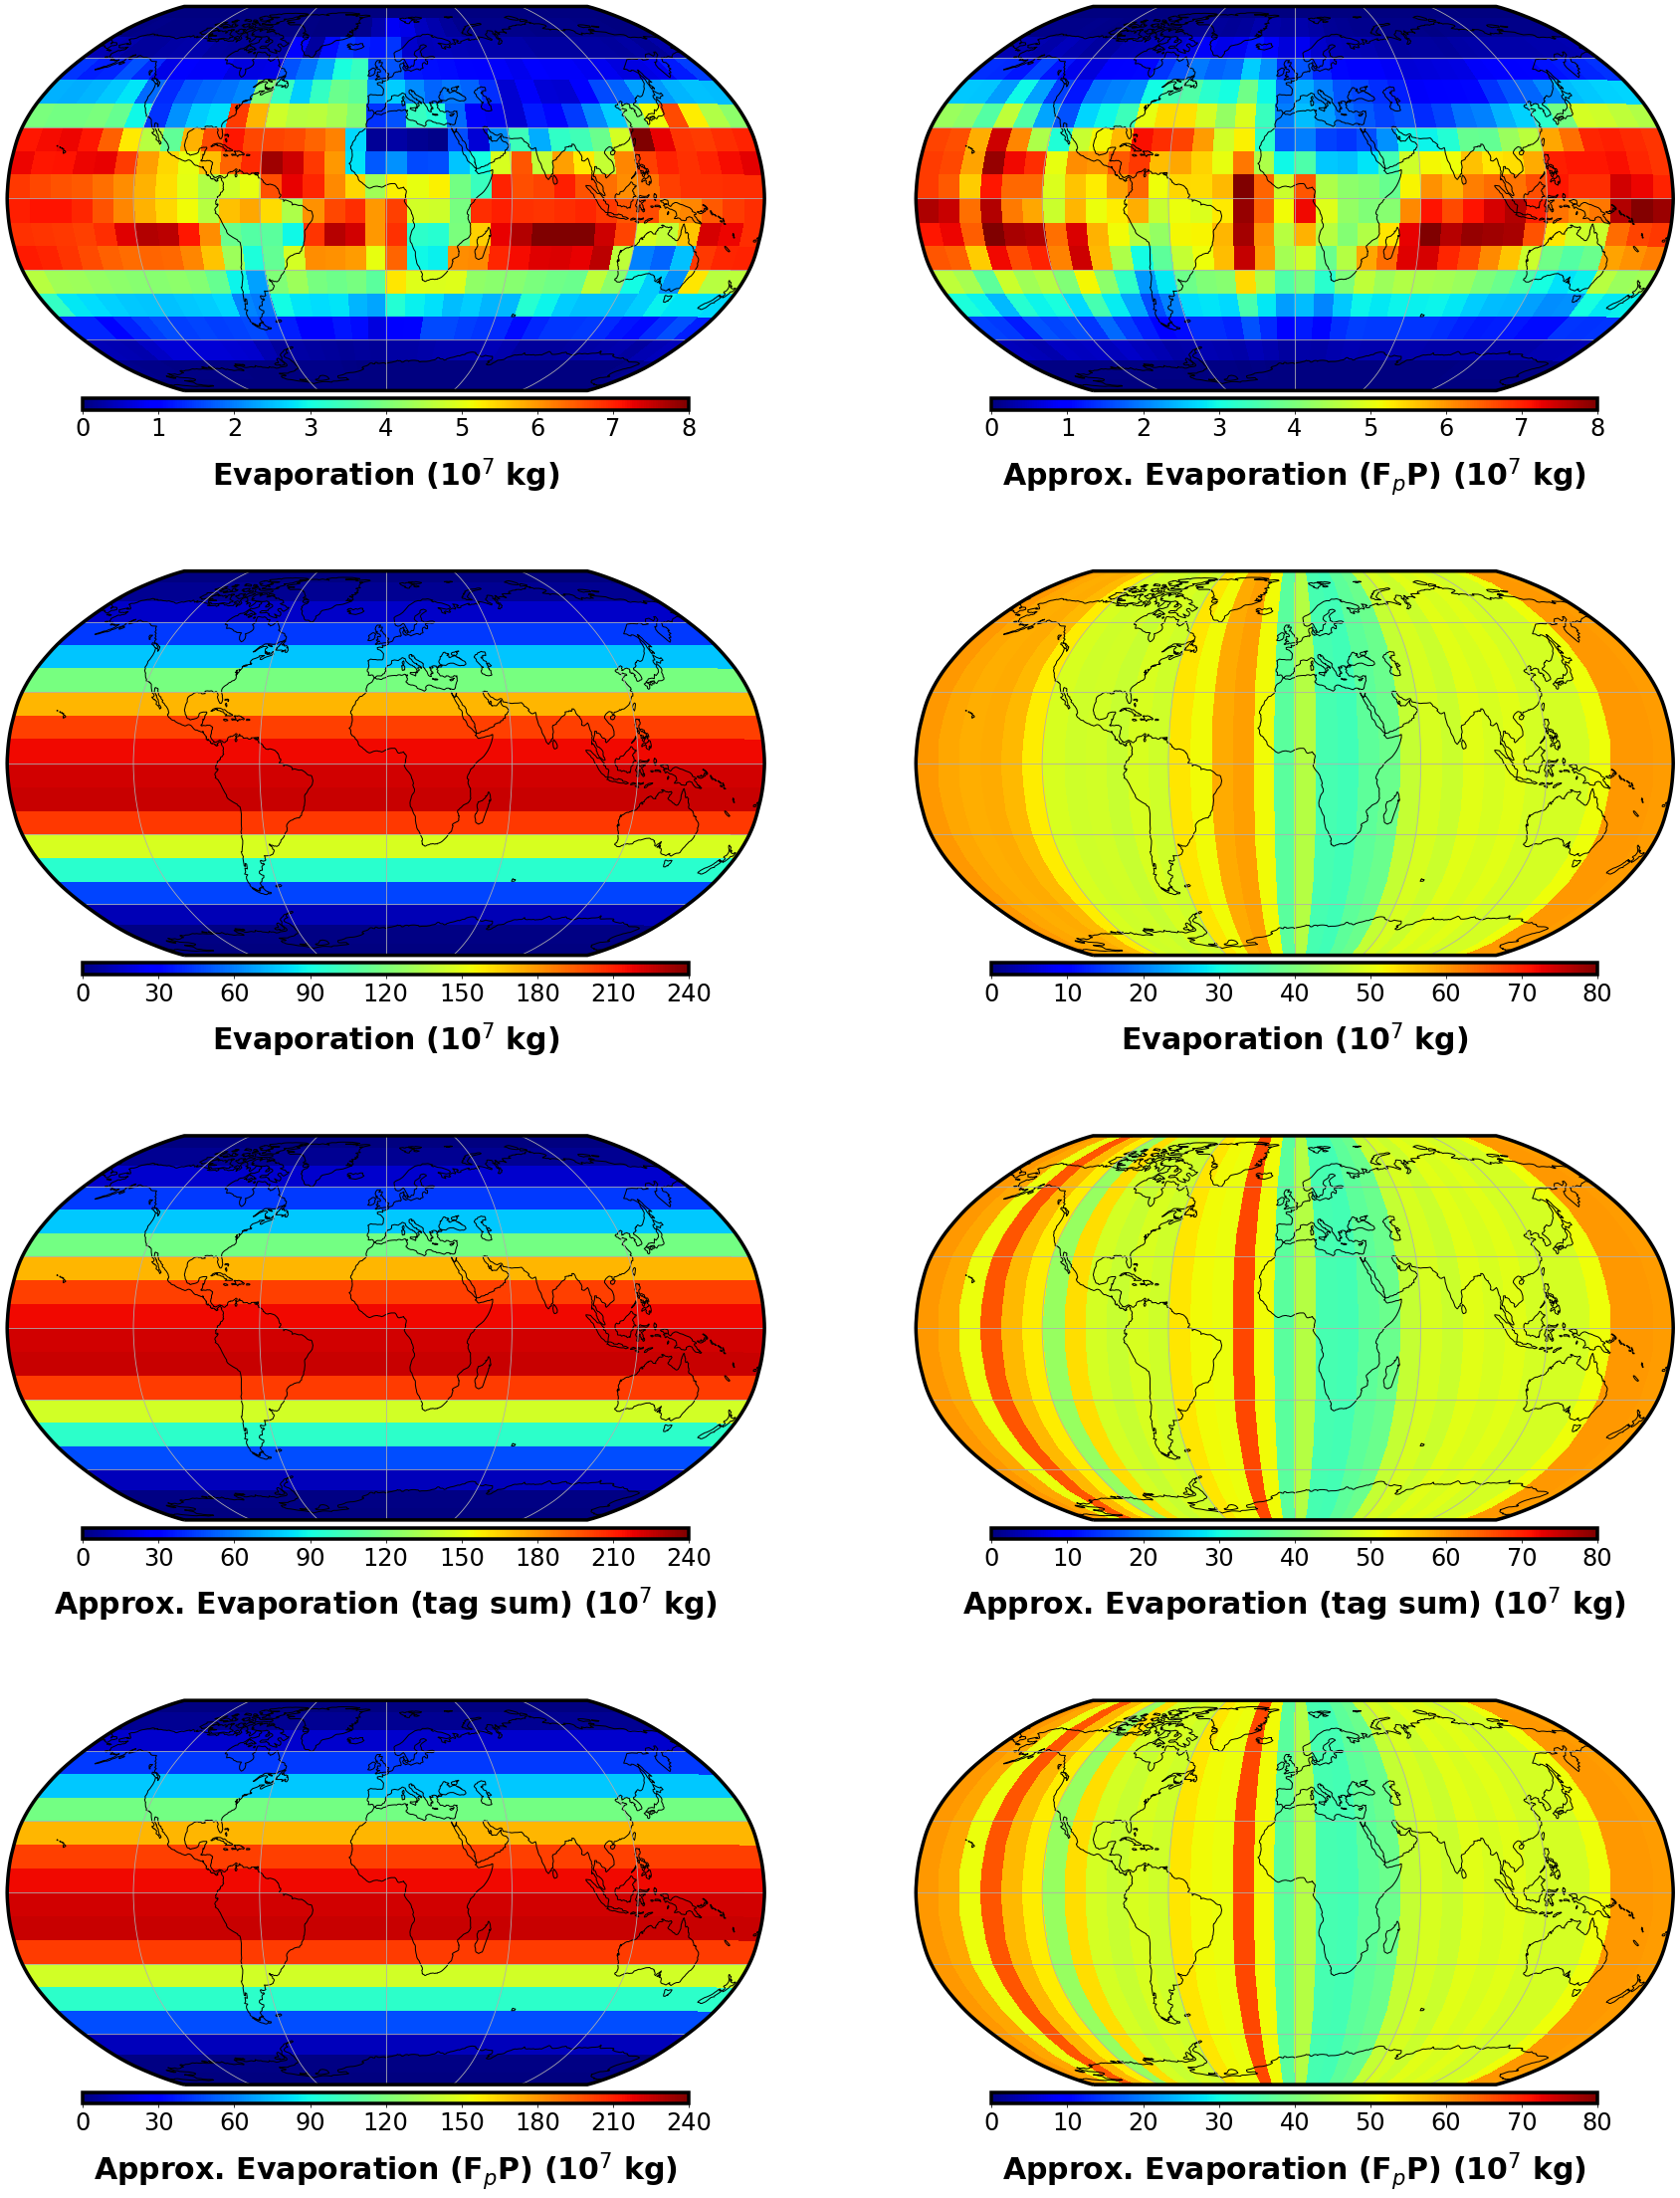

In [231]:

fs1 = 30
fs2 = 24

fig = plt.figure(figsize=(30,40))

widths = [1,1]
heights = [1,1,1,1]
gs = fig.add_gridspec(nrows=len(heights), ncols=len(widths), width_ratios=widths, height_ratios=heights)

##############

ax = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
term = E_base
vmin, vmax= 0, 8
nticks = 9
cblabel = 'Evaporation (10$^{7}$ kg)'
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

##############

ax = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
term = Fp_base@P_base
vmin, vmax= 0, 8
nticks = 9
cblabel = 'Approx. Evaporation (F$_{p}$P) (10$^{7}$ kg)'
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, np.reshape(term,(ntag_lat,ntag_lon))/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

##############

term_lon1, term_lat1 = np.meshgrid(e_lon_base_gr,e_lat_base_gr)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson())
cblabel = 'Evaporation (10$^{7}$ kg)'
term_lon, term_lat = np.meshgrid(e_lon_base_gr,e_lat_base_gr)
nticks = 9
vmin, vmax= 0, 8*30
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lat1/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson())
cblabel = 'Evaporation (10$^{7}$ kg)'
vmin, vmax= 0, 8*10
nticks = 9
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lon1/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

##############

term_lon2, term_lat2 = np.meshgrid(pr_lon_tag_base_gr.sum(axis=1),pr_lat_tag_base_gr.sum(axis=1))

ax = fig.add_subplot(gs[2, 0], projection=ccrs.Robinson())
cblabel = 'Approx. Evaporation (tag sum) (10$^{7}$ kg)'
term_lon, term_lat = np.meshgrid(e_lon_base_gr,e_lat_base_gr)
nticks = 9
vmin, vmax= 0, 8*30
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lat2/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

ax = fig.add_subplot(gs[2, 1], projection=ccrs.Robinson())
cblabel = 'Approx. Evaporation (tag sum) (10$^{7}$ kg)'
vmin, vmax= 0, 8*10
nticks = 9
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lon2/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

##############

term_lon3, term_lat3 = np.meshgrid(np.reshape(Fp_base@P_base,(ntag_lat,ntag_lon)).sum(axis=0),
                                 np.reshape(Fp_base@P_base,(ntag_lat,ntag_lon)).sum(axis=1))

ax = fig.add_subplot(gs[3, 0], projection=ccrs.Robinson())
cblabel = 'Approx. Evaporation (F$_{p}$P) (10$^{7}$ kg)'
term_lon, term_lat = np.meshgrid(e_lon_base_gr,e_lat_base_gr)
nticks = 9
vmin, vmax= 0, 8*30
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lat3/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

ax = fig.add_subplot(gs[3, 1], projection=ccrs.Robinson())
cblabel = 'Approx. Evaporation (F$_{p}$P) (10$^{7}$ kg)'
vmin, vmax= 0, 8*10
nticks = 9
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_tags, lat_tags, term_lon3/1e7, transform=ccrs.PlateCarree(), cmap='jet', vmin=vmin, vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks))
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)